In [122]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations
import community
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr
import scipy.odr as odr

In [2]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [139]:
tree_sizeize

50

In [3]:
random.seed(12345)
np.random.seed(12345)
fixed_tree = ete3.Tree()
tree_size  = 50
taxa       = []
loop_count = 0
while len(taxa) < tree_size:
    if tree_size <= 25:
        for chr_number in range(97, 97+tree_size):
            taxa.append(chr(chr_number))
    else:
        loop_count += 1
        for chr_number in range(97, 123):
            taxa.append('%s%i' %(chr(chr_number), loop_count))
        taxa = taxa[:tree_size]
            
#taxa = set(taxa)
fixed_tree.populate(size=tree_size, names_library=taxa, random_branches=True)
for node in fixed_tree.traverse():
    node.img_style["size"] = 0
fixed_tree.dist = 0.1
print(fixed_tree)


               /-y1
            /-|
           |   \-x1
           |
           |      /-w1
         /-|   /-|
        |  |  |  |   /-v1
        |  |  |   \-|
        |  |  |      \-u1
        |  |  |
        |   \-|      /-t1
        |     |   /-|
        |     |  |   \-s1
        |     |  |
        |     |  |      /-r1
        |      \-|   /-|
        |        |  |  |   /-q1
        |        |  |   \-|
        |        |  |     |   /-p1
        |         \-|      \-|
      /-|           |         \-o1
     |  |           |
     |  |           |   /-n1
     |  |            \-|
     |  |               \-m1
     |  |
     |  |         /-l1
     |  |      /-|
     |  |     |  |   /-k1
     |  |     |   \-|
     |  |   /-|      \-j1
     |  |  |  |
     |  |  |  |   /-i1
     |  |  |   \-|
     |  |  |      \-h1
     |   \-|
     |     |      /-g1
     |     |   /-|
     |     |  |   \-f1
     |     |  |
     |     |  |      /-e1
     |      \-|   /-|
     |        |  |  |   /-d1
   /-| 

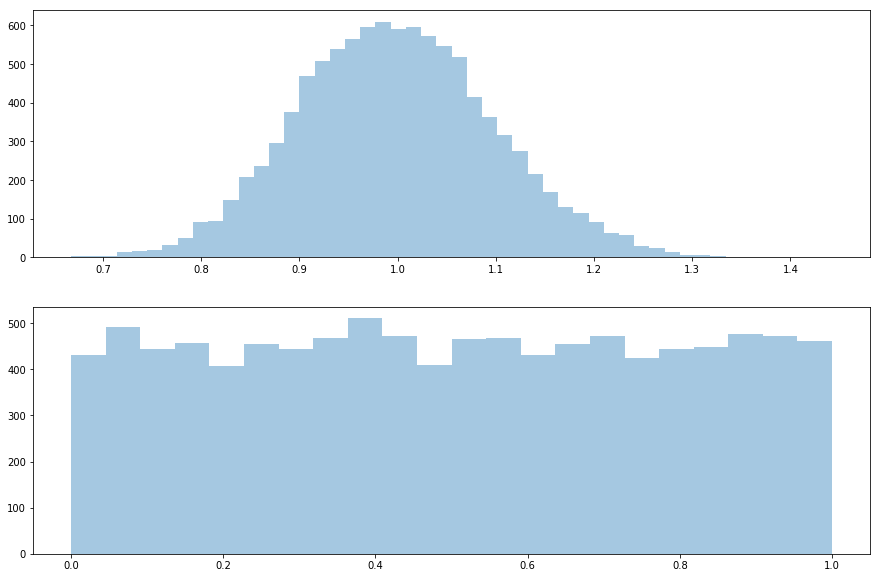

In [4]:
with pm.Model() as model:
    alpha = 1/np.mean([node.dist for node in fixed_tree.traverse()
                       if not node.is_root()])
    br_length_scale   = pm.Gamma('br_length_scale', 100, 100)
    point_of_transfer = pm.Uniform('point_of_transfer', lower=0, upper=1)

fig, axs = plt.subplots(figsize=(15, 10), nrows=2)
sample   = br_length_scale.random(size=10000)
sns.distplot(sample, kde=False, ax=axs[0])
sample   = point_of_transfer.random(size=10000)
sns.distplot(sample, kde=False, ax=axs[1]);

In [5]:
ts = ete3.TreeStyle()
ts.show_branch_length = True

np.random.seed(12345)
random.seed(12345)
tree         = fixed_tree.copy()
topologies   = [tree.copy()]
topology_ids = set(tree.get_topology_id())
tree.render(file_name="tree_%i.png" % len(topologies), dpi=100, w=500, units='px', tree_style=ts)
while len(topologies) < 10:
    starting_tree = tree.copy()
    
    pruned_node    = random.choice([node for node in tree.traverse()
                                    if tree.get_distance(node, topology_only=True) > 0]).copy()
    pruned_node.dist *= br_length_scale.random()
    
    tree.prune(set(taxa).difference(pruned_node.get_leaf_names()), preserve_branch_length=True)

    source = random.choice([node for node in tree.traverse()
                            if not node.is_root()])

    source.add_sister(pruned_node)
    tree.resolve_polytomy()

    topology_id = tree.get_topology_id()
    if topology_id in topology_ids:
        tree = starting_tree.copy()
        continue
    
    if pruned_node.is_leaf():
        recipient = tree.get_leaves_by_name(pruned_node.name)[0]
    else:
        recipient = tree.get_common_ancestor(pruned_node.get_leaf_names())
    
    topology_ids.add(topology_id)
    topologies.append(tree.copy())

In [6]:
geodesic_dists = pd.read_csv('geodesic_distances.tab', sep='\t', index_col=0)
rf_dists       = pd.read_csv(      'rf_distances.tab', sep='\t', index_col=0)

In [7]:
geodesic_dists

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,3.317818,3.431769,3.724193,4.439473,5.466732,5.562140,5.570878,5.643612,5.666962
tree_1,3.317818,0.000000,0.878623,1.692500,4.277106,5.333474,5.430994,5.440060,5.515275,5.549634
tree_2,3.431769,0.878623,0.000000,1.446575,4.203000,5.367143,5.466444,5.475450,5.595558,5.627579
tree_3,3.724193,1.692500,1.446575,0.000000,3.946218,5.446412,5.493022,5.502451,5.625078,5.669529
tree_4,4.439473,4.277106,4.203000,3.946218,0.000000,4.361127,4.382671,4.691413,5.503283,5.502678
tree_5,5.466732,5.333474,5.367143,5.446412,4.361127,0.000000,3.579688,4.312557,5.184102,5.183460
tree_6,5.562140,5.430994,5.466444,5.493022,4.382671,3.579688,0.000000,3.501616,4.508333,5.009769
tree_7,5.570878,5.440060,5.475450,5.502451,4.691413,4.312557,3.501616,0.000000,3.291541,3.941461
tree_8,5.643612,5.515275,5.595558,5.625078,5.503283,5.184102,4.508333,3.291541,0.000000,3.770473
tree_9,5.666962,5.549634,5.627579,5.669529,5.502678,5.183460,5.009769,3.941461,3.770473,0.000000


In [8]:
spr_distances  = pd.DataFrame(index  =['tree_%i' % num for num in range(len(topologies))],
                              columns=['tree_%i' % num for num in range(len(topologies))],
                              data=[abs(np.arange(10)-n) for n in range(10)])
spr_distances

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0,1,2,3,4,5,6,7,8,9
tree_1,1,0,1,2,3,4,5,6,7,8
tree_2,2,1,0,1,2,3,4,5,6,7
tree_3,3,2,1,0,1,2,3,4,5,6
tree_4,4,3,2,1,0,1,2,3,4,5
tree_5,5,4,3,2,1,0,1,2,3,4
tree_6,6,5,4,3,2,1,0,1,2,3
tree_7,7,6,5,4,3,2,1,0,1,2
tree_8,8,7,6,5,4,3,2,1,0,1
tree_9,9,8,7,6,5,4,3,2,1,0


In [9]:
distance_matrices = {}
for count, tree in enumerate(topologies):
    patristic_distances = []
    for taxon1, taxon2 in combinations(taxa, 2):
        patristic_distances.append(tree.get_distance(taxon1, taxon2))
    distance_matrices['tree_%i' % count] = pd.DataFrame(index=taxa, 
                                                        columns=taxa, 
                                                        data=squareform(patristic_distances))

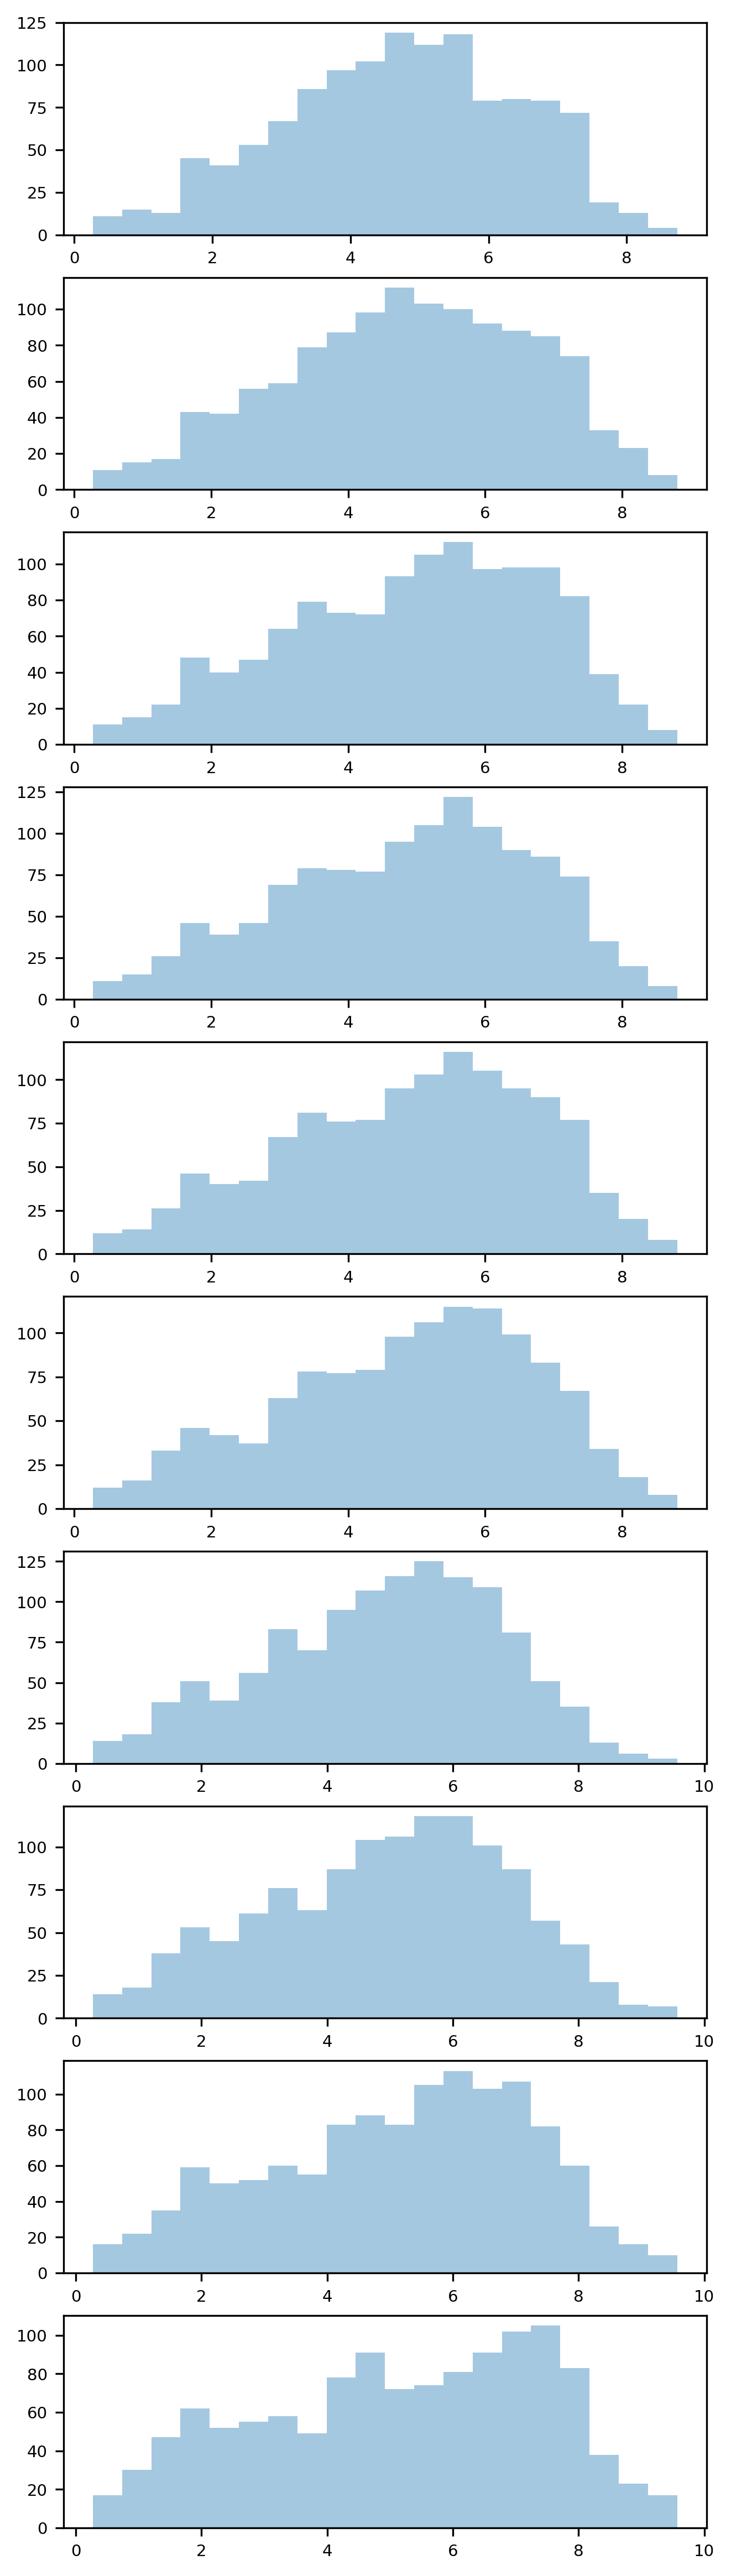

In [11]:
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(figsize=(5,20), dpi=300, nrows=len(distance_matrices))
family_clusters = {}
for num in range(len(topologies)):
    df = distance_matrices['tree_%i' % num]
    sns.distplot(squareform(df.values), kde=False, ax=ax[num], bins=20)

In [10]:
family_corrs = []
for family1, family2 in combinations(distance_matrices.keys(), 2):
    family_corrs.append(
        pearsonr(
            squareform(distance_matrices[family1].values),
            squareform(distance_matrices[family2].values)
    )[0])
family_corrs = pd.DataFrame(index  =distance_matrices.keys(),
                            columns=distance_matrices.keys(),
                            data=squareform(family_corrs))
family_corrs

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.908209,0.905677,0.889527,0.844369,0.705304,0.677656,0.594884,0.487915,0.411740
tree_1,0.908209,0.000000,0.988581,0.975381,0.923426,0.793814,0.766990,0.682142,0.545729,0.441190
tree_2,0.905677,0.988581,0.000000,0.987703,0.936989,0.811910,0.785792,0.699086,0.577897,0.470187
tree_3,0.889527,0.975381,0.987703,0.000000,0.946812,0.825148,0.801627,0.713252,0.589406,0.482822
tree_4,0.844369,0.923426,0.936989,0.946812,0.000000,0.879220,0.856210,0.762092,0.631671,0.506357
tree_5,0.705304,0.793814,0.811910,0.825148,0.879220,0.000000,0.964904,0.866629,0.731788,0.615743
tree_6,0.677656,0.766990,0.785792,0.801627,0.856210,0.964904,0.000000,0.899405,0.764464,0.653516
tree_7,0.594884,0.682142,0.699086,0.713252,0.762092,0.866629,0.899405,0.000000,0.865583,0.752801
tree_8,0.487915,0.545729,0.577897,0.589406,0.631671,0.731788,0.764464,0.865583,0.000000,0.851315
tree_9,0.411740,0.441190,0.470187,0.482822,0.506357,0.615743,0.653516,0.752801,0.851315,0.000000


In [11]:
pearsonr(squareform(spr_distances), squareform(family_corrs))

(-0.8909701550260167, 2.4338361489709e-16)

In [12]:
X = squareform(distance_matrices['tree_0'].values)
sorted_matrices = np.asarray([squareform(distance_matrices['tree_%i' % num]) for num in range(10)])

In [14]:
df_data = pd.DataFrame(dict(x=sorted_matrices[0], y=sorted_matrices[1]))
cov = df_data.cov()

In [18]:
df_data.x.shape[0]

1225

In [212]:
#https://docs.scipy.org/doc/scipy/reference/odr.html
#https://towardsdatascience.com/total-least-squares-in-comparison-with-ols-and-odr-f050ffc1a86a

def odr_line(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + 0

def perform_odr(x, y):
    quadr  = odr.Model(odr_line)
    mydata = odr.Data(df_data.x, df_data.y, we=np.ones(df_data.shape[0]), wd=np.ones(df_data.shape[0]))
    myodr  = odr.ODR(mydata, quadr, beta0=[1., 0.])
    output = myodr.run()
    return output

regression = perform_odr(df_data.x, df_data.y)
yest_odr   = odr_line(regression.beta, data)

In [213]:
regression.pprint()

Beta: [1.03583397 0.        ]
Beta Std Error: [0.00435 0.     ]
Beta Covariance: [[6.78108257e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 0.2790486421279491
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


In [201]:
regression.pprint()

Beta: [1.03583397 0.        ]
Beta Std Error: [0.00435 0.     ]
Beta Covariance: [[6.78108257e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 0.2790486421279491
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


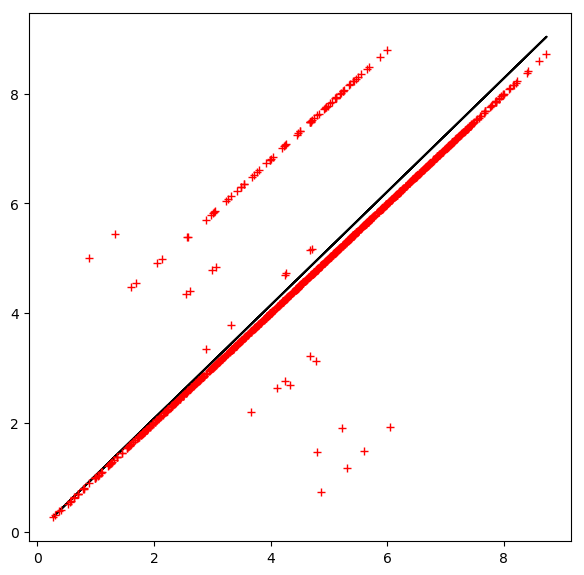

In [214]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax.plot(df_data.x, regression.beta[0] * df_data.x, '-k', alpha=1)

ax.plot(df_data.x, df_data.y, '+r');

In [167]:
#
# https://discourse.pymc.io/t/errors-in-variables-model-in-pymc3/3519/2

#most tweaked
with pm.Model() as model:
    err_x     = pm.HalfNormal('err_x',     sigma=20.)
    err_y     = pm.HalfNormal('err_y',     sigma=20.)
    err_slope = pm.HalfNormal('err_slope', sigma=5.)
    
    slope     = pm.Normal('slope', mu=0, sigma=err_slope)
    nu        = pm.Uniform('nu', lower=1, upper=tree_size)
    
    true_x = pm.Normal('true_x',  mu=df_data.x.mean(), sigma=20.)
    x_obs  = pm.StudentT('x_obs', mu=true_x, sigma=err_x, nu=nu, observed=df_data.x, shape=df_data.shape[0])
    
    y_pred = pm.Deterministic('y_pred', slope * true_x)
    y_obs  = pm.StudentT('y', mu=y_pred, sigma=err_y, nu=nu, observed=df_data.y)
    
    trace = pm.sample(2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_x, nu, slope, err_slope, err_y, err_x]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1444.69draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8829997268662906, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [164]:
pm.waic(trace, model)

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=12491.46907670372, WAIC_se=69.65694245445951, p_WAIC=1192.4053896239425, var_warn=1)

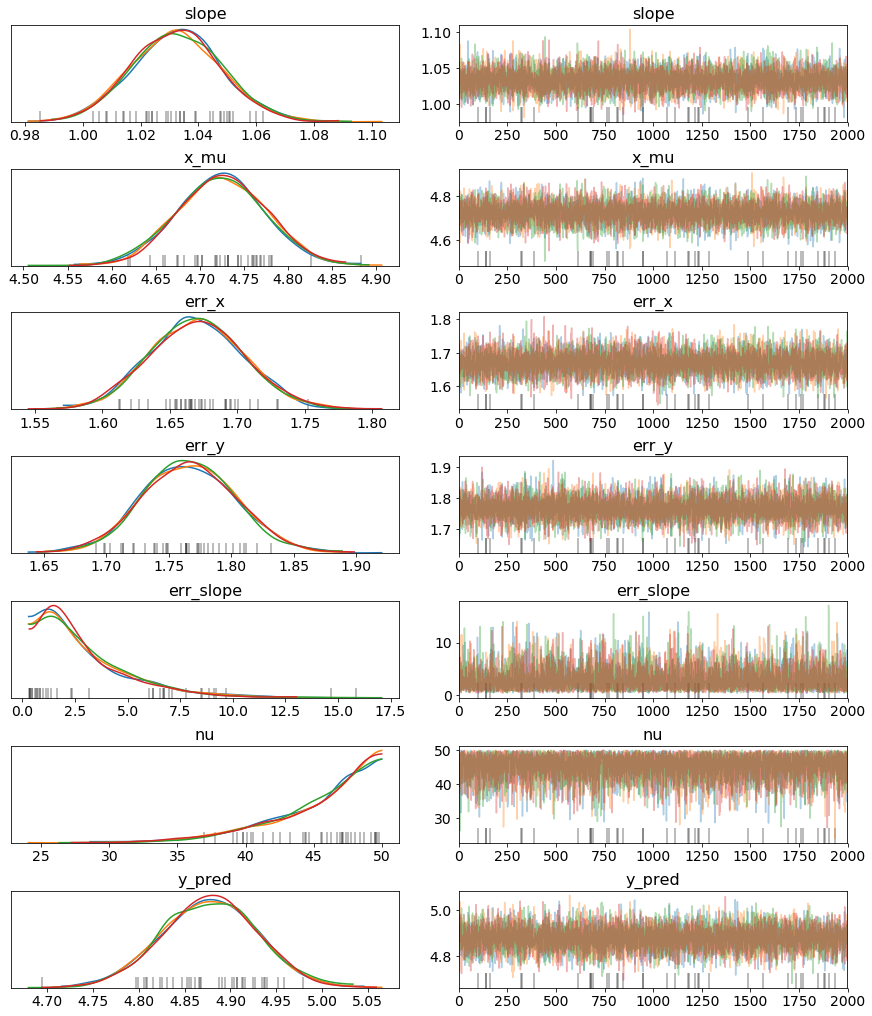

In [153]:
pm.traceplot(trace);

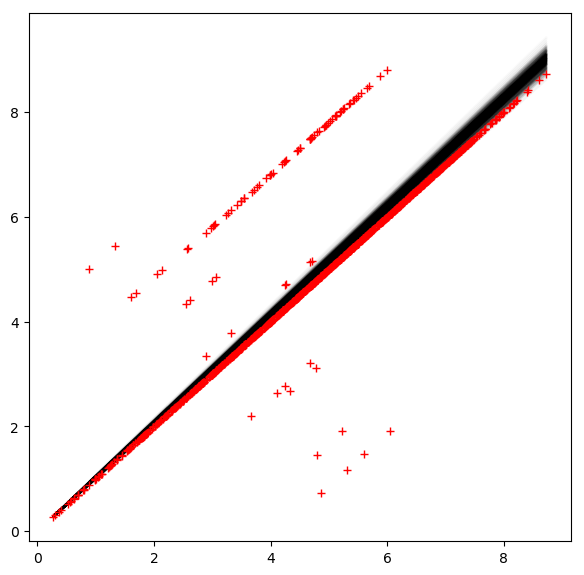

In [165]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
for sample in trace[-1000:]:
    ax.plot(df_data.x, sample['slope'] * df_data.x, '-k', alpha=0.01)

ax.plot(df_data.x, df_data.y, '+r');

In [171]:
#
# https://discourse.pymc.io/t/errors-in-variables-model-in-pymc3/3519/2

#classic ODR
with pm.Model() as model:
    err_odr   = pm.HalfNormal('err_odr',   sigma=20., shape=df_data.shape[0])
    err_slope = pm.HalfNormal('err_slope', sigma=20.)
    
    slope     = pm.Normal('slope', mu=0, sigma=err_slope)
    nu        = pm.Uniform('nu', lower=1, upper=tree_size)
    
    true_x = pm.Normal('true_x',  mu=df_data.x.mean(), sigma=20.)
    x_obs  = pm.StudentT('x_obs', mu=true_x, sigma=err_odr, nu=nu, observed=df_data.x, shape=df_data.shape[0])
    
    y_pred = pm.Deterministic('y_pred', slope * true_x)
    y_obs  = pm.StudentT('y', mu=y_pred, sigma=err_odr, nu=nu, observed=df_data.y)
    
    trace = pm.sample(2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/thiberio/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_x, nu, slope, err_slope, err_odr]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:16<00:00, 130.28draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7124773550645325, but should be close to 0.8. Try to increase the number of tuning steps.
There were 281 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6029249090085563, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accep

In [173]:
pm.waic(trace, model)

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=11490.90739721526, WAIC_se=62.03961318272456, p_WAIC=1669.3540942255884, var_warn=1)

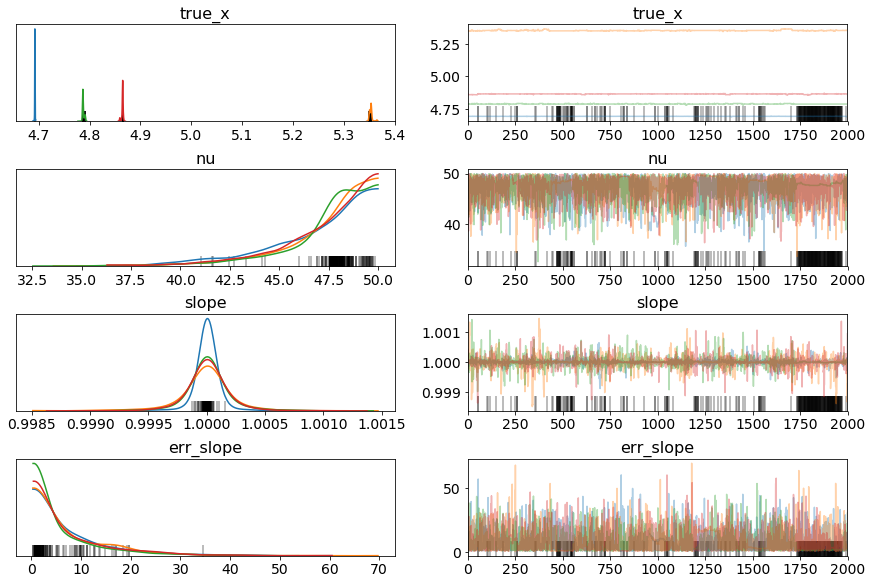

In [177]:
pm.traceplot(trace, var_names=['true_x', 'nu', 'slope', 'err_slope']);

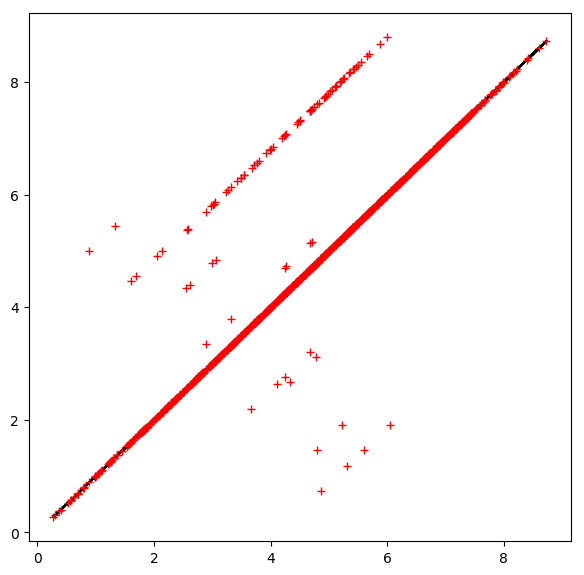

In [178]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
for sample in trace[-1000:]:
    ax.plot(df_data.x, sample['slope'] * df_data.x, '-k', alpha=0.01)

ax.plot(df_data.x, df_data.y, '+r');

In [393]:
models = []
traces = []
for count, condensed in enumerate(sorted_matrices):
    with pm.Model() as tmp_model:
        slope     = pm.HalfNormal('slope', sigma=10)
        intercept = 0

        estimator   = intercept + slope * X
        nu          = pm.Uniform('nu', lower=1, upper=100)
        likelihood  = pm.StudentT('likelihood', 
                                  mu=estimator, 
                                  sigma=2,
                                  nu=nu,
                                  observed=condensed)

        tmp_trace = pm.sample(2_000, chains=2, cores=10)
    
    tmp.name = 'tree_%i' % count
    
    models.append(tmp_model)
    traces.append(tmp_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [nu, slope]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1477.11draws/s]
The acceptance probability does not match the target. It is 0.8804748230455474, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [nu, slope]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1558.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [nu, slope]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1568.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [nu, slope]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1529.36d

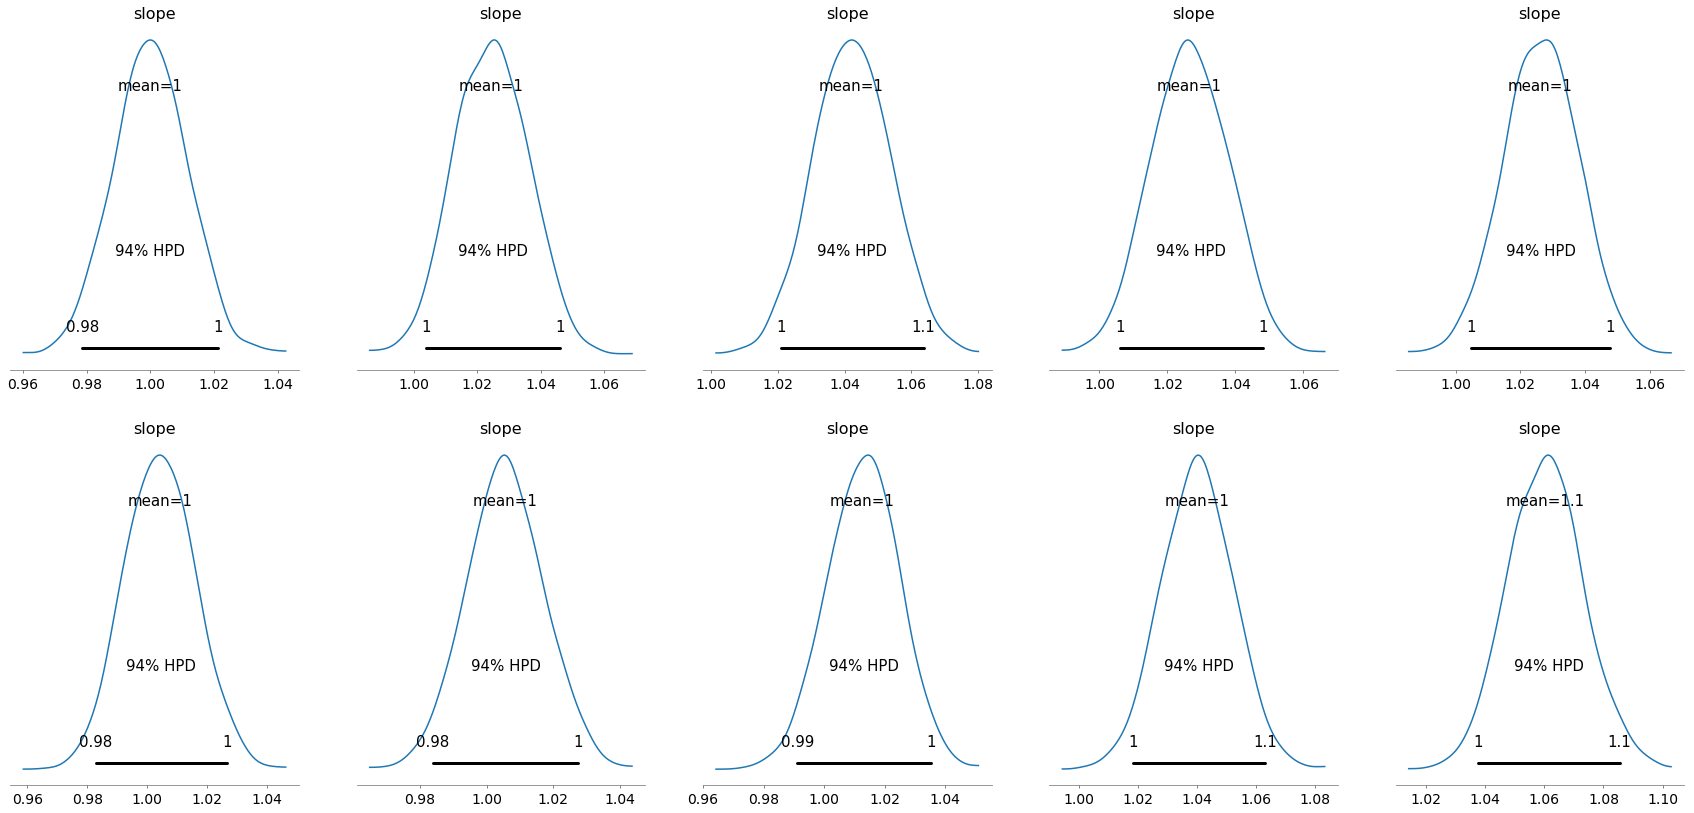

In [404]:
fig, axs = plt.subplots(figsize=(30,14), ncols=5, nrows=2)
for sample, ax in zip(traces, chain(*axs)):
    pm.plot_posterior(sample, var_names=['slope'], ax=ax);

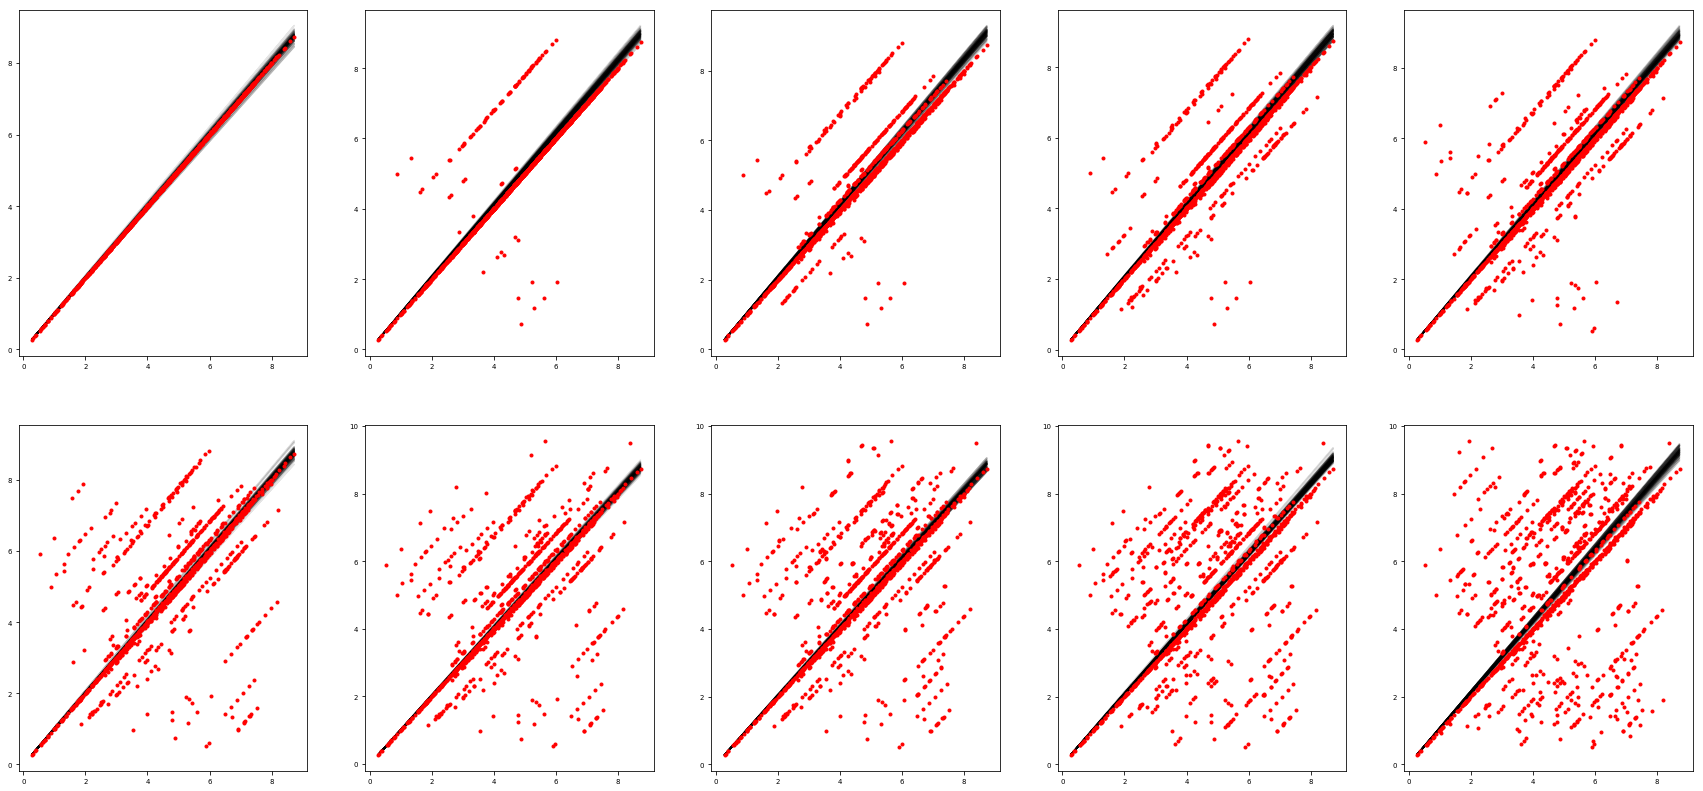

In [402]:
fig, axs = plt.subplots(figsize=(30,14), ncols=5, nrows=2)

reg_line = lambda x, slope: slope * x
for sample, condensed, ax in zip(traces, sorted_matrices, chain(*axs)):
    for slope in sample['slope'][-100:]:
        ax.plot(X, reg_line(X, slope), '-k', alpha=0.1)
    
    ax.plot(X, condensed, '.r', label='data')

In [397]:
pm.compare(dict(zip(models, traces)))

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
tree_0,3958.2,0,0,1,0.02,0,0
tree_1,4134.08,0.11,175.88,0,18.84,18.84,0
tree_2,4148.11,0.13,189.91,0,18.1,18.1,0
tree_3,4174.19,0.15,215.99,0,18.22,18.22,0
tree_4,4262.57,0.2,304.37,0,27.04,27.04,0
tree_5,4521.21,0.56,563.01,0,45.24,45.24,0
tree_6,4583.32,0.61,625.12,0,46.31,46.31,0
tree_7,4790.28,1.05,832.09,0,51.37,51.36,0
tree_8,5116.58,1.56,1158.39,0,54.53,54.53,0
tree_9,5383.26,1.38,1425.07,0,59.28,59.28,0
